# Huấn luyện Phân loại Giới tính với Dataset từ Kaggle
Notebook này huấn luyện mô hình CNN để phân loại giới tính sử dụng dataset Gender Classification đã tải về local.

**Nguồn Dataset**: https://www.kaggle.com/datasets/cashutosh/gender-classification-dataset

In [21]:
# Import các thư viện cần thiết
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [22]:
# Khám phá cấu trúc dataset
data_dir = './dataset/gender'
print("Cấu trúc dataset:")
for root, dirs, files in os.walk(data_dir):
    level = root.replace(data_dir, '').count(os.sep)
    indent = ' ' * 2 * level
    print(f"{indent}{os.path.basename(root)}/")
    subindent = ' ' * 2 * (level + 1)
    for file in files[:3]:  # Chỉ hiển thị 3 file đầu tiên
        print(f"{subindent}{file}")
    if len(files) > 3:
        print(f"{subindent}... và {len(files) - 3} file khác")

Cấu trúc dataset:
gender/
  Training/
    female/
      131422.jpg.jpg
      131423.jpg.jpg
      131425.jpg.jpg
      ... và 23240 file khác
    male/
      090544.jpg.jpg
      090545.jpg.jpg
      090548.jpg.jpg
      ... và 23763 file khác
  Validation/
    female/
      112944.jpg.jpg
      112950.jpg.jpg
      112953.jpg.jpg
      ... và 5838 file khác
    male/
      063429.jpg.jpg
      063430.jpg.jpg
      063438.jpg.jpg
      ... và 5805 file khác


In [23]:
# Định nghĩa các lớp giới tính (dựa trên cấu trúc dataset thực tế)
# Dataset sẽ tự động phát hiện các lớp từ tên thư mục
gender_labels = ['Nam', 'Nữ']  # Nhãn chuẩn để hiển thị
num_classes = 2

print(f"Huấn luyện với {num_classes} lớp giới tính: {gender_labels}")
print("Dataset sẽ tự động phát hiện cấu trúc thư mục cho tên lớp")

Huấn luyện với 2 lớp giới tính: ['Nam', 'Nữ']
Dataset sẽ tự động phát hiện cấu trúc thư mục cho tên lớp


In [24]:
# Tiền xử lý và tăng cường dữ liệu (giảm augmentation để training nhanh hơn)
train_datagen = ImageDataGenerator(
    rescale=1.0/255,
    rotation_range=10,  # Giảm từ 20 xuống 10
    width_shift_range=0.1,  # Giảm từ 0.2 xuống 0.1
    height_shift_range=0.1,  # Giảm từ 0.2 xuống 0.1
    horizontal_flip=True,
    fill_mode='nearest'
)

# Generator cho dữ liệu validation (chỉ rescaling)
validation_datagen = ImageDataGenerator(rescale=1.0/255)

In [25]:
# Tải dữ liệu training từ thư mục Training
# Tăng batch_size và giảm kích thước ảnh để training nhanh hơn
train_generator = train_datagen.flow_from_directory(
    directory="./dataset/gender/Training",
    target_size=(96, 96),  # Kích thước vừa phải: 96x96
    batch_size=32,  # Batch size tiêu chuẩn
    class_mode='categorical',
    shuffle=True
)

# Tải dữ liệu validation từ thư mục Validation
validation_generator = validation_datagen.flow_from_directory(
    directory="./dataset/gender/Validation",
    target_size=(96, 96),  # Kích thước vừa phải: 96x96
    batch_size=32,  # Batch size tiêu chuẩn
    class_mode='categorical',
    shuffle=False
)

# In thông tin các lớp được phát hiện
print(f"Các lớp được phát hiện: {train_generator.class_indices}")
print(f"Số lượng mẫu training: {train_generator.n}")
print(f"Số lượng mẫu validation: {validation_generator.n}")

Found 47009 images belonging to 2 classes.
Found 11649 images belonging to 2 classes.
Các lớp được phát hiện: {'female': 0, 'male': 1}
Số lượng mẫu training: 47009
Số lượng mẫu validation: 11649


In [26]:
# Xây dựng mô hình CNN cho phân loại giới tính (tối ưu hóa cho tốc độ)
model = Sequential()

# Các lớp Convolutional (cân bằng giữa tốc độ và chất lượng)
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(96, 96, 3)))
model.add(MaxPooling2D(2, 2))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(2, 2))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(2, 2))

# Flatten
model.add(Flatten())

# Các lớp fully-connected
model.add(Dense(128, activation='relu'))  # Tăng lại lên 128 để cân bằng
model.add(Dropout(0.4))  # Dropout vừa phải

# Lớp output (2 lớp cho giới tính)
model.add(Dense(2, activation='softmax'))

# Hiển thị kiến trúc mô hình
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_7 (Conv2D)           (None, 94, 94, 32)        896       
                                                                 
 max_pooling2d_7 (MaxPoolin  (None, 47, 47, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_8 (Conv2D)           (None, 45, 45, 64)        18496     
                                                                 
 max_pooling2d_8 (MaxPoolin  (None, 22, 22, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_9 (Conv2D)           (None, 20, 20, 128)       73856     
                                                                 
 max_pooling2d_9 (MaxPoolin  (None, 10, 10, 128)      

In [27]:
# Compile mô hình với optimizer Adam (thường nhanh hơn RMSprop)
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Callbacks để tối ưu hóa training
early_stopping = EarlyStopping(
    patience=3, 
    monitor='val_loss', 
    restore_best_weights=True
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=2,
    min_lr=0.0001
)

In [28]:
# Huấn luyện mô hình (giảm epochs để training nhanh hơn)
print("Bắt đầu huấn luyện mô hình...")
history = model.fit(
    train_generator,
    steps_per_epoch=min(100, train_generator.n // train_generator.batch_size),  # Tăng steps để cân bằng
    epochs=15,  # Tăng epochs lên 15
    validation_data=validation_generator,
    validation_steps=min(50, validation_generator.n // validation_generator.batch_size),  # Tăng validation steps
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)
print("Hoàn thành huấn luyện!")

Bắt đầu huấn luyện mô hình...
Epoch 1/15
100/100 [==============================] - 25s 232ms/step - loss: 0.6713 - accuracy: 0.5850 - val_loss: 0.4231 - val_accuracy: 0.8675 - lr: 0.0010
Epoch 2/15
100/100 [==============================] - 38s 379ms/step - loss: 0.5670 - accuracy: 0.7300 - val_loss: 0.4508 - val_accuracy: 0.7962 - lr: 0.0010
Epoch 3/15
100/100 [==============================] - 31s 306ms/step - loss: 0.4916 - accuracy: 0.7716 - val_loss: 0.5300 - val_accuracy: 0.7419 - lr: 0.0010
Epoch 4/15
100/100 [==============================] - 29s 285ms/step - loss: 0.4241 - accuracy: 0.8112 - val_loss: 0.2104 - val_accuracy: 0.9319 - lr: 2.0000e-04
Epoch 5/15
100/100 [==============================] - 29s 285ms/step - loss: 0.4037 - accuracy: 0.8263 - val_loss: 0.2536 - val_accuracy: 0.8969 - lr: 2.0000e-04
Epoch 6/15
100/100 [==============================] - 28s 278ms/step - loss: 0.3897 - accuracy: 0.8403 - val_loss: 0.2023 - val_accuracy: 0.9331 - lr: 2.0000e-04
Epoch 7/15

In [29]:
# Đánh giá mô hình
score = model.evaluate(validation_generator, verbose=0)
print(f'Loss trên tập test: {score[0]:.4f}')
print(f'Độ chính xác trên tập test: {score[1]:.4f}')

Loss trên tập test: 0.3119
Độ chính xác trên tập test: 0.8789


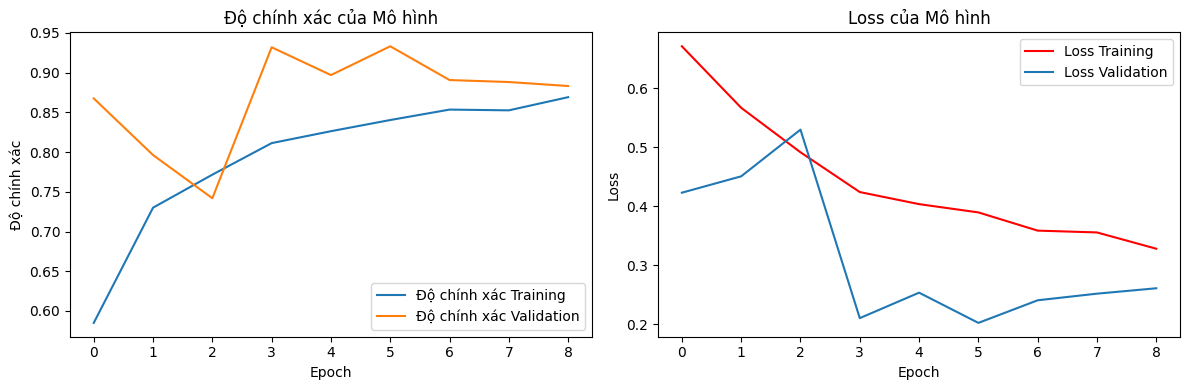

In [30]:
# Vẽ biểu đồ lịch sử huấn luyện
plt.figure(figsize=(12, 4))

# Vẽ biểu đồ độ chính xác
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Độ chính xác Training')
plt.plot(history.history['val_accuracy'], label='Độ chính xác Validation')
plt.title('Độ chính xác của Mô hình')
plt.ylabel('Độ chính xác')
plt.xlabel('Epoch')
plt.legend()

# Vẽ biểu đồ loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], 'r', label='Loss Training')
plt.plot(history.history['val_loss'], label='Loss Validation')
plt.title('Loss của Mô hình')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()

plt.tight_layout()
plt.show()

In [31]:
# Lưu mô hình đã huấn luyện
model.save('Gender1.h5')  # Đổi tên từ Gender2 thành Gender1 để nhất quán
print("Mô hình đã được lưu với tên 'Gender1.h5'")

Mô hình đã được lưu với tên 'Gender1.h5'


In [32]:
# Kiểm tra mô hình với ảnh mẫu
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import load_img, img_to_array
import numpy as np

# Tải mô hình đã lưu
model_CNN = load_model('Gender1.h5')  # Cập nhật tên file

# Định nghĩa nhãn dự đoán
predict_labels = ['Nam', 'Nữ']

# Hàm dự đoán giới tính từ đường dẫn ảnh
def predict_gender(image_path):
    try:
        # Tải và tiền xử lý ảnh
        img = load_img(image_path, target_size=(96, 96))  # Cập nhật kích thước
        plt.figure(figsize=(6, 6))
        plt.imshow(img)
        plt.title('Ảnh đầu vào')
        plt.axis('off')
        plt.show()
        
        # Chuyển đổi thành array và chuẩn hóa
        img_array = img_to_array(img)
        img_array = img_array.reshape(1, 96, 96, 3)  # Cập nhật kích thước
        img_array = img_array.astype('float32') / 255.0
        
        # Thực hiện dự đoán
        prediction = model_CNN.predict(img_array)
        predicted_class = np.argmax(prediction, axis=-1)[0]
        confidence = np.max(prediction)
        
        print(f"Giới tính dự đoán: {predict_labels[predicted_class]}")
        print(f"Độ tin cậy: {confidence:.2%}")
        
        return predict_labels[predicted_class], confidence
    except Exception as e:
        print(f"Lỗi khi xử lý ảnh: {e}")
        return None, None

# Ví dụ sử dụng (bỏ comment và cung cấp đường dẫn ảnh hợp lệ)
# predict_gender('./dataset/gender/Training/female/sample_image.jpg')